<a href="https://colab.research.google.com/github/urvashisirohi8/Assignment/blob/main/M4_AST_18_Neural_Machine_Translation_with_Custom_Dataset_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Programme in Deep Learning (Foundations and Applications)
## A Program by IISc and TalentSprint
### Assignment 18: Natural Language Processing - (Translate human readable dates to machine readable dates)

### Learning Objectives:

At the end of the experiment, you will be able to:

*  perform seq2seq translation
*  use attention architecture for machine translation tasks
*  Visualize the parts of the input to which every output pays attention to, while doing the translation.


### Problem Statement


**Translating human readable dates into machine readable dates**

The model you will build here could be used to translate from one language to another, such as translating from English to Hindi. However, language translation requires massive datasets and usually takes days of training on GPUs. To give you a place to experiment with these models even without using massive datasets, we will instead use a simpler "date translation" task.


The network will input a date written in a variety of possible formats (e.g. "the 29th of August 1958", "03/30/1968", "24 JUNE 1987") and translate them into standardized, machine readable dates (e.g. "1958-08-29", "1968-03-30", "1987-06-24"). We will have the network learn to output dates in the common machine-readable format YYYY-MM-DD.

You will build a Neural Machine Translation (NMT) model to translate human readable dates ("25th of June, 2009") into machine readable dates ("2009-06-25"). You will do this using an attention model, one of the most sophisticated sequence to sequence models.

###  Dataset

We will train the model on a dataset of 50000 human readable dates and their equivalent, standardized, machine readable dates.

### Setup Steps:

In [ ]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "" #@param {type:"string"}

In [ ]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "" #@param {type:"string"}

In [ ]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython
import warnings
warnings.filterwarnings("ignore")

ipython = get_ipython()

notebook= "M4_AST_18_Neural_Machine_Translation_with_Custom_Dataset_C" #name of the notebook

def setup():
    ipython.magic("sx wget https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/dates_dataset.csv")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer1() and getAnswer2() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer1" : Answer1, "answer2" : Answer2, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://learn-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer1():
  try:
    if not Answer1:
      raise NameError
    else:
      return Answer1
  except NameError:
    print ("Please answer Question 1")
    return None

def getAnswer2():
  try:
    if not Answer2:
      raise NameError
    else:
      return Answer2
  except NameError:
    print ("Please answer Question 2")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



### Importing required packages

In [ ]:
import torch,os
import numpy as np
import pandas as pd
import random,os,sys
# The date and time functionality provided by Babel lets you format
# standard Python datetime, date and time objects and work with timezones.
from babel.dates import format_date
import matplotlib.pyplot as plt
from functools import partial
from tqdm import tqdm

### Loading the dates dataset

In [ ]:
dates = pd.read_csv("dates_dataset.csv")
dates.columns = ["human_readable", "machine_readable"]
dates.head()

In [ ]:
# Print the shape of the dataset
dates.shape

In [ ]:
# Cosidering 40000 dates for training set
n_datas = 40000
dt_train = dates.iloc[:n_datas]
print(dt_train.shape)

### Helper Function for Human readable and machine readable dates

We are loading the below:

**X:** a processed version of the human readable dates in the training set, where each character is replaced by an index mapped to the character via human_vocab. Each date is further padded to  30 values (human_readable_length) with a special character (< pad >).

**Y:** a processed version of the machine readable dates in the training set, where each character is replaced by the index it is mapped to in machine_vocab.

**Xoh:** one-hot version of X, the "1" entry's index is mapped to the character to human_vocab. Xoh.shape = (no. of dates, 30, len(human_vocab)). Here len(human_vocab) = 36

**Yoh:** one-hot version of Y, the "1" entry's index is mapped to the character to machine_vocab. Yoh.shape = (no. of dates, 10, len(machine_vocab)). Here, len(machine_vocab) = 11 since there are 11 characters ('-' as well as 0-9).


In [ ]:
# Let's preprocess the data and map the raw text data into the index values
def transform(human_readable, machine_readable, human_vocab, machine_vocab, human_readable_length):

    # For every item(x) in human readable we are getting corresponding keys from human_vocab
    # If the key doesn't exist we return <unk> token
    # Converting dates which are in string format to integer
    # will return a list of indexes based on a string and vocabulary
    X = list(map(lambda x: human_vocab.get(x, '<unk>'), human_readable))

    # will return a list of indexes based on a string and vocabulary
    # human_readable_length=30 (which we assume is the maximum length of the human readable date
    # if we get a longer input, we would have to truncate it)
    # If the input is less than the maximum length we add the padding
    # We also add two special chars, <unk> for unknown characters, and <pad> to add padding at the end
    if len(X) < human_readable_length:
        X += [human_vocab['<pad>']] * (human_readable_length - len(X))
    elif len(X) > human_readable_length:
        X = X[:30]

    # Y=10 (since "YYYY-MM-DD" is 10 characters long)
    # If the key doesn't exist we return <unk> token
    Y = list(map(lambda x: machine_vocab.get(x, '<unk>'), machine_readable)) # len(Y) is always 10, because the format is YYYY-MM-DD

    def zcs(length, idx):
        ret = np.zeros(length)
        ret[idx] = 1
        return ret

    Xoh = np.array(list(map(partial(zcs, len(human_vocab)), X)), dtype=np.float32)
    Yoh = np.array(list(map(partial(zcs, len(machine_vocab)), Y)), dtype=np.float32)

    return Xoh, Yoh, {'human_readable':human_readable, 'machine_readable':machine_readable}

**dataset:** a list of tuples of (human readable date, machine readable date).

**human_vocab:** a python dictionary mapping all characters used in the human readable dates to an integer-valued index.

For Example **human_vocab** looks like the below dictionary:

{' ': 0,
 '.': 1,
 '/': 2,
 '0': 3,
 '1': 4,
 '2': 5,
 '3': 6,
 '4': 7,
 '5': 8,
 '6': 9,
 '7': 10,
 '8': 11,
 '9': 12,
 '<pad>': 36,
 '<unk>': 35,
 'a': 13,
 'b': 14,
 'c': 15,
 'd': 16,
 'e': 17,
 'f': 18,
 'g': 19,
 'h': 20,
 'i': 21,
 'j': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'r': 28,
 's': 29,
 't': 30,
 'u': 31,
 'v': 32,
 'w': 33,
 'y': 34}

**machine_vocab:** a python dictionary mapping all characters used in machine readable dates to an integer-valued index. These indices are not necessarily consistent with human_vocab.

For Example **machine_vocab** looks like the below dictionary:

{'-': 0,
 '0': 1,
 '1': 2,
 '2': 3,
 '3': 4,
 '4': 5,
 '5': 6,
 '6': 7,
 '7': 8,
 '8': 9,
 '9': 10}



**inv_machine_vocab:** the inverse dictionary of machine_vocab, mapping from indices back to characters.

For Example **inv_machine_vocab:** looks like the below dictionary:

{0: '-',
 1: '0',
 2: '1',
 3: '2',
 4: '3',
 5: '4',
 6: '5',
 7: '6',
 8: '7',
 9: '8',
 10: '9'}

### Custom Dataset Class for reading the dates data

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, transform, dates = dt_train, n_datas=40000, seed=12345):

        # Transformations defined above
        self.transform = transform

        # Human and machine readable dates(40000)
        self.human_readable = dt_train['human_readable']
        self.machine_readable = dt_train['machine_readable']

        self.human_readable_length = 30 # the maximum length of input sequence is 30
        self.human_vocab = set()
        self.machine_vocab = set()
        self.dataset = []
        for i in tqdm(range(n_datas)):
            human_readable, machine_readable = dt_train.iloc[i]["human_readable"].rstrip()[1:-1], dt_train.iloc[i]["machine_readable"].rstrip()[2:-1]
            # print(human_readable, machine_readable)

            self.dataset.append((human_readable, machine_readable))
            self.human_vocab.update(tuple(human_readable))
            self.machine_vocab.update(tuple(machine_readable))

        self.human_vocab = dict(zip(sorted(self.human_vocab) + ['<unk>', '<pad>'], list(range(len(self.human_vocab) + 2))))

        # Mapping indexes back to the characters
        self.inv_machine_vocab = dict(enumerate(sorted(self.machine_vocab)))

        self.machine_vocab = {v:k for k, v in self.inv_machine_vocab.items()}
        print(f"human_vocab : {self.human_vocab}")
        print(f"machine_vocab : {self.machine_vocab}")
        print(f"inverse_vocab : {self.inv_machine_vocab}")

    def __getitem__(self, idx):
        human_readable, machine_readable = self.dataset[idx] # dataset is a list of tuples
        return self.transform(human_readable, machine_readable, self.human_vocab, self.machine_vocab, self.human_readable_length)

    def __len__(self):
        return len(self.dataset)

### Loading the data using pytorch data loader

In [ ]:
dataset = Dataset(dates = dt_train, transform = transform)

**torch.utils.data.DataLoader** class represents a Python iterable over a dataset, with following features.

1. Batching the data - `batch_size`, which denotes the number of samples contained in each generated batch. The Machine learning dataset can be really large. Hence we cannot often load the entire data into the memory. Hence neural network training is done by loading small batches (commonly called minibatch) of data and using it to update the learnable parameters (weights and biases) of the model.

2. Shuffling the data - If set to `shuffle=True`, we will get a new order of exploration at each pass. Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. By performing it will eventually make our model more robust.



In [ ]:
dataloader = torch.utils.data.DataLoader(dataset=dataset,
                                        batch_size=100,
                                        shuffle=False,
                                        num_workers=0,
                                        collate_fn=None)

Iterate through the dataset and print the shape of the input and output batches

In [ ]:
for i, batch_x in enumerate(dataloader):
    print(batch_x[0].shape, batch_x[0])
    print(batch_x[1].shape, batch_x[1])
    if i >= 1:
        break

### Neural Machine Translation (NMT) with Attention


NMT is a problem where we process an input sequence to produce an output sequence — that is, a sequence-to-sequence (seq2seq) problem. Specifically, the many-to-many type, with a sequence of several elements both at the input and at the output, and the encoder-decoder architecture for recurrent neural networks is the standard method.

Initially machine translation (MT) problems were faced using statistical approaches, based mainly on Bayes probabilities. But when neural networks became more powerful and popular, researchers began to explore the capabilities of this technology and new solutions were found. It is called neural machine translation (NMT).

The model based on RNNs has a serious problem when working with long sequences because the information of the first tokens is lost or diluted as more tokens are processed. The context vector has been given the responsibility of encoding all of the information in a given source sentence into a vector of few hundred elements. It made it challenging for the models to deal with long sentences.

In this paper https://arxiv.org/pdf/1409.0473.pdf


They introduce a technique called **attention**, which highly improved the quality of machine-translation systems. “**Attention** allows the model to focus on the relevant parts of the input sequence as needed, accessing all the past hidden states of the encoder, instead of just the last one”.

At each decoding step, the decoder gets to look at any particular state of the encoder and can selectively pick out specific elements from that sequence to produce the output.

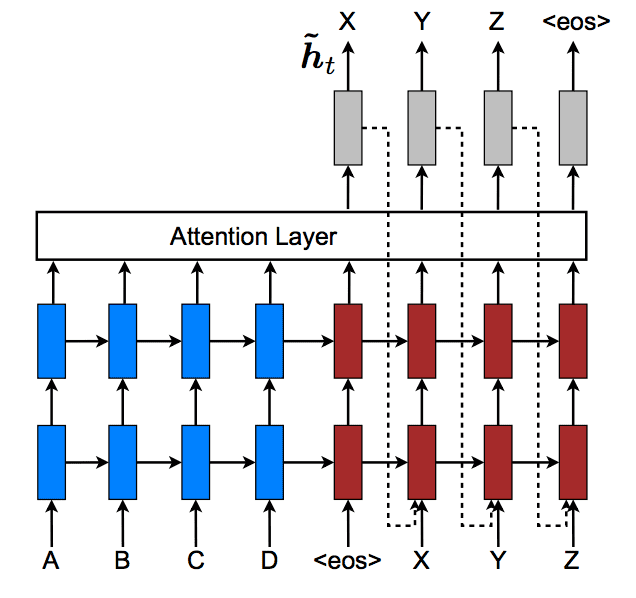

**Note:**

1. Refer to the following [link](https://towardsdatascience.com/attn-illustrated-attention-5ec4ad276ee3) to understand more in detail about the Attention Machanism.

2.  Refer to the following [link](https://betterprogramming.pub/a-guide-on-the-encoder-decoder-model-and-the-attention-mechanism-401c836e2cdb) to understand Encoder-Decoder Model and the Attention Mechanism.






## A BASIC LSTM-BASED ENCODER & DECODER MODEL


<center>
<img src="https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/LSTM_1.png" width="800" height="500">
</center>

### Define Encoder Architecture (Bi-directional LSTM)

Encoder cell are simple RNN cell (LSTM or GRU can be used for better performance) which takes the input vectors. The input is taken as a single character at each and every time stamp but the out is not taken at each state. Output of each encoder cell is rejected and internal state are used to generate encoder vector.



The input tokens/characters one hot vectors are fed one at a time into the forward LSTM network and the backward LSTM network simultaneously. Then the hidden states
emitted by both networks at each timestep are concentrated to form a single hidden state.

During the decoding process, the context vector at each timestep is
calculated through the attention layer. Then the decoder predicts future observations one by one by making use of the context vector and the current hidden state.

In [ ]:
# Bi-directional LSTM as Encoder Model
# We give the human readable vocab to the encoder and it should generate a vector that represents the inputs
# Encoder processes the input and provides the context vector
# (Last time step's hidden state + Last time step's cell state) for the decoder.
class Encoder(torch.nn.Module):
    def __init__(self, in_features=36, hidden_size=64):
        super(Encoder, self).__init__()
        # Input features (human vocabulary) = 36 and hidden size = 64
        self.linear = torch.nn.Linear(in_features=in_features, out_features=hidden_size)
        self.relu = torch.nn.ReLU()
        # Bi-directional LSTM
        self.lstm = torch.nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        self.lstm.flatten_parameters()
        x, _ = self.lstm(x)
        return x

### Define Decoder Architecture (Single LSTM)

Same as encoder decoder also consist of series of RNN/LSTM. Here we are taking an output at each time stamp t.
Each RNN/LSTM cell produce output y_t with the previous output y_t-1 and hidden state ht-1. Output y_t is calculated with ht and y_t-1. we use softmax function to determine the output as this prediction is probabilistic.

In [ ]:
# Decoder Architecture
# Now to generate the machine readable dates, we will make another LSTM which is the decoder.
# Attention weights are used to specify which characters are needed — when to generate a character/output
class Decoder(torch.nn.Module):
    def __init__(self, in_features=128, hidden_size=128):
        super(Decoder, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=in_features, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=False)
        self.linear = torch.nn.Linear(in_features=hidden_size, out_features=11)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x, h, c):
        self.lstm.flatten_parameters()
        x, (h, c) = self.lstm(x, (h, c))
        x = self.linear(x.squeeze())
        x = self.softmax(x)
        return x, (h, c)

### Combining Encoder-Attention-Decoder

<center>
<img src="https://cdn.iisc.talentsprint.com/DLFA/Experiment_related_data/LSTM_2.png" width="850" height="500">
</center>

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, output_len, use_gpu=True):
        super(Model, self).__init__()
        self.output_len = output_len
        self.use_gpu = use_gpu
        # Encoder
        self.encoder = Encoder(in_features=36, hidden_size=64)
        # Decoder
        self.decoder = Decoder(in_features=128, hidden_size=128)

        # Attention network
        self.linear1 = torch.nn.Linear(in_features=128+128, out_features=10)
        self.tanh = torch.nn.Tanh()
        self.linear2 = torch.nn.Linear(in_features=10, out_features=1)
        self.softmax = torch.nn.Softmax(dim=1) # this is important
        self.scores_for_paint = []

    def forward(self, x):
        # The pre-attention Bi-LSTM goes through 30 time steps; the post-attention LSTM goes through 10 time steps.
        # Encoder output is calculated only once
        feats = self.encoder(x) #(N, 30, 128)

        # First, we initialize zeros for Hidden state and cell state of first decoder unit
        # and use gpu
        if self.use_gpu:
            decoder_h = torch.zeros((1, feats.shape[0], 128)).cuda() #(1, N, 128)
            decoder_c = torch.zeros((1, feats.shape[0], 128)).cuda() #(1, N, 128)
        else:
            decoder_h = torch.zeros((1, feats.shape[0], 128)) #(1, N, 128)
            decoder_c = torch.zeros((1, feats.shape[0], 128)) #(1, N, 128)

        # Initialize empty list of outputs
        outputs = []
        self.scores_for_paint = []

        # Decoder loop repeats 10 times as output sequence is 10
        for _ in range(self.output_len):

            # Reshape decoder cell state
            feats_2 = decoder_c.transpose(0, 1) #(1, N, 128) --> (N, 1, 128)
            feats_2 = feats_2.repeat(1, feats.shape[1], 1) #(N, 1, 128) --> (N, 30, 128), because the max length of feats.shape[1] is 30

            # The decoder hidden state and encoder hidden states are added together first before being passed through a linear layer with a tanh activation
            feats_in = torch.cat((feats, feats_2), dim=-1) # (N, 30, 128) and (N, 30, 128) --> (N, 30, 256)

            # Attention starts here
            out = self.tanh(self.linear1(feats_in)) #(N, 30, 256) --> (N, 30, 10)

            # These softmaxed scores represent the attention distribution
            scores = self.softmax(self.linear2(out)) #(N, 30, 10) --> (N, 30, 1)
            # print(scores[0, :, 0])

            if not self.training:
                self.scores_for_paint.append(scores.squeeze().detach().cpu().numpy())
                # print(scores)

            # multiplying each encoder hidden state with its softmaxed score (scalar) we obtain the alignment vector
            # and sum up the alignment vectors to produce context vector
            # A context vector is aggregated information of the alignment vectors from the previous step.
            feats_for_decoder = torch.mul(feats, scores).sum(axis=1).unsqueeze(1) #(N, 30, 128) mul (N, 30, 1) --> (N, 30, 128) --> (N, 128) --> (N, 1, 128)
            # Attention ends here

            # Feed the context vector to the decoder
            # Decoder calculates ouput token prediction and returns hidden state, cell state
            decoder_out, (decoder_h, decoder_c) = self.decoder(feats_for_decoder, decoder_h, decoder_c) #run lstm only one step, because feats_for_decoder.shape is (N, 1, 128)
            outputs.append(decoder_out.unsqueeze(1)) #list of (N, 1, 11)
            # print(decoder_out.shape) #loop ends here

        outputs = torch.cat(outputs, dim=1) #(N, 10, 11)
        return outputs

    def total_parameters(self):
        return sum([p.numel() for p in self.parameters()])

In [ ]:
model = Model(output_len=10, use_gpu=False)
print(model)

In [ ]:
print('model size is %.3f KB' % (model.total_parameters() * 4 / 1024))

### Helper function for calculating accuracy

In [ ]:
def calc_accuracy(pred, answer):
    pred = np.argmax(pred, axis=2)
    answer = np.argmax(answer, axis=2)
    correct = (pred == answer).astype(int)
    accuracy = correct.sum() / (pred.shape[0] * pred.shape[1])
    return accuracy

### Helper function for training the attention network

In [ ]:
def train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=False):
    pbar = tqdm(total=len(dataloader), bar_format='{l_bar}{r_bar}', dynamic_ncols=True)
    pbar.set_description(f'Epoch %d' % epoch)

    for step, (batch_x, batch_y, _) in enumerate(dataloader):
        if use_gpu:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
        pred = model(batch_x)
        accuracy = calc_accuracy(pred.detach().cpu().numpy(), batch_y.detach().cpu().numpy())
        loss = loss_fn(pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(**{'loss':loss.detach().cpu().item(), 'accuracy':accuracy})
        pbar.update()
    save_checkpoint('./checkpoint', epoch, model, optimizer)

    pbar.close()

### Saving the model checkpoints

In [ ]:
# For each epoch save the model and load the last epoch checkpoint
def find_last_checkpoint(checkpoint_dir):
    epochs = []
    for name in os.listdir(checkpoint_dir):
        if os.path.splitext(name)[-1] == '.pth':
            epochs += [int(name.strip('ckpt_epoch_.pth'))]
    if len(epochs) == 0:
        raise IOError('no checkpoint found in {}'.format(checkpoint_dir))
    return max(epochs)

# Save the checkpoint at each epoch
def save_checkpoint(checkpoint_dir, epoch, model, optimizer=None):
    checkpoint = {}
    checkpoint['epoch'] = epoch

    if isinstance(model, torch.nn.DataParallel):
        model_state_dict = model.module.state_dict()
    else:
        model_state_dict = model.state_dict()
    checkpoint['model'] = model_state_dict

    if optimizer is not None:
        optimizer_state_dict = optimizer.state_dict()

        checkpoint['optimizer'] = optimizer_state_dict
    else:
        checkpoint['optimizer'] = None

    torch.save(checkpoint, os.path.join(checkpoint_dir, 'ckpt_epoch_%02d.pth'% epoch))

# Load the saved checkpoint
def load_checkpoint(checkpoint_dir, epoch=-1):
    if epoch == -1:
        epoch = find_last_checkpoint(checkpoint_dir)
    checkpoint_name = 'ckpt_epoch_%02d.pth'% epoch
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_name)
    ckpt = torch.load(checkpoint_path, map_location='cpu')
    return ckpt

# Saving the trained model
def save_model(checkpoint_dir, epoch, model):
    save_checkpoint(checkpoint_dir, epoch, model, optimizer=None)

# Loading the model
def load_model(checkpoint_dir, epoch, model):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        model_state_dict = ckpt['model']

        if isinstance(model, torch.nn.DataParallel):
            model.module.load_state_dict(model_state_dict)

        else:
            model.load_state_dict(model_state_dict)
    except Exception as e:
        print('failed to load model, {}'.format(e))
    return model

# Load the optimizer as a state dictionary
def load_optimizer(checkpoint_dir, epoch, optimizer):
    try:
        ckpt = load_checkpoint(checkpoint_dir, epoch)
        optimizer_state_dict = ckpt['optimizer']
        optimizer.load_state_dict(optimizer_state_dict)
    except Exception as e:
        print('failed to load optimizer, {}'.format(e))
    return optimizer

### Training the model

In [ ]:
if not os.path.exists("checkpoint"):
  os.mkdir("checkpoint")

In [ ]:
def main(dataloader, gpu_id=None,):

    dataloader = dataloader

    model = Model(output_len=10, use_gpu=True if gpu_id is not None else False)
    if gpu_id is not None:
        print('use gpu')
        os.environ["CUDA_VISIBLE_DEVICES"] = gpu_id
        n_gpus = torch.cuda.device_count()
        model = model.cuda()

    # Mean Square Error loss between actual and predictions
    loss_fn = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters())

    model = load_model('./checkpoint', -1, model)
    optimizer = load_optimizer('./checkpoint', -1, optimizer)

    try:
        trained_epoch = find_last_checkpoint('./checkpoint')
        print('train form epoch %d' % (trained_epoch + 1))
    except Exception as e:
        print('train from the very begining, {}'.format(e))
        trained_epoch = -1
    for epoch in range(trained_epoch+1, 10):
        train(model, loss_fn, optimizer, dataloader, epoch, use_gpu=True if gpu_id is not None else False)


if len(sys.argv) == 1:
    main(dataloader,gpu_id='0')
else:
    main(dataloader,gpu_id=None)

### Testing the model with 10000 test examples

In [ ]:
n_datas = 10000
dt_test = dates.iloc[40000:]
dataset = Dataset(dates = dt_test,transform=transform, n_datas = 10000)

### Evaluating the model
#### Here we are evaluating the model and plotting the attention

In [ ]:
model = Model(output_len=10, use_gpu=False)
try:
    trained_epoch = find_last_checkpoint('./checkpoint')
    print('load model %d' % (trained_epoch))
except Exception as e:
    print('no trained model found, {}'.format(e))

model = load_model('./checkpoint', -1, model)

# Set the model to eval mode
model.eval()

for i in range(1):
  x, y, extra = dataset.__getitem__(i)

  # Pass the predictions to the model
  pred = model(torch.from_numpy(x).unsqueeze(0))

  # Max probability of the predictions
  pred = np.argmax(pred.detach().numpy(), axis=0)

  # Map the vocab indexes back to the characters
  pred = ''.join([dataset.inv_machine_vocab[p] for p in pred])

  human_readable = extra['human_readable']
  machine_readable = extra['machine_readable']

  print('%s --> %s, true_value: %s' % (human_readable, pred, machine_readable))
  # print(len(model.scores_for_paint), model.scores_for_paint[0].shape)
  scores = np.array(model.scores_for_paint)

  f = plt.figure(figsize=(8, 8.5))
  ax = f.add_subplot(1, 1, 1)
  i = ax.imshow(scores, interpolation='nearest', cmap='Blues')

  ax.set_xticks(range(10))
  ax.set_xticklabels(human_readable[:10], rotation=0)

  ax.set_yticks(range(10))
  ax.set_yticklabels(machine_readable[:10], rotation=0)

  plt.savefig('./attention.png')

### Calculating the Accuracy

In [ ]:
correct = 0
for i in tqdm(range(10000)):
  x, y, extra = dataset.__getitem__(i)

  pred = model(torch.from_numpy(x).unsqueeze(0))

  pred = np.argmax(pred.detach().numpy(), axis=0)

  pred = ''.join([dataset.inv_machine_vocab[p] for p in pred])

  human_readable = extra['human_readable']
  machine_readable = answer = extra['machine_readable']

  # print('%s --> %s, true_value: %s' % (human_readable, pred, machine_readable))
  # print(len(model.scores_for_paint), model.scores_for_paint[0].shape)
  scores = np.array(model.scores_for_paint)


  # print(pred,answer)
  if pred == answer:
    correct += 1
accuracy = correct / (10000)
print(accuracy)

In [ ]:
print(f"Test Accuracy : {accuracy}")

### Please answer the questions below to complete the experiment:




In [ ]:
#@title Q.1. The output of the attention model that serves as an input to the decoder is referred to as the  ____________________.
Answer1 = "" #@param ["","attention sequence","attention weights","context vector","reference input"]


In [ ]:
#@title Q.2. How does the attention mechanism help the decoder while generating output?
Answer2 = "" #@param ["","It allows the decoder to use only a limited amount of information from the input","It allows the decoder to store additional state about past information in the sequence","It allows the decoder to selectively pick important elements from the input sequence at each time instance","It allows the decoder to forget irrelevant portions of the past information in the sequence"]


In [ ]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [ ]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "" #@param {type:"string"}


In [ ]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "" #@param ["","Yes", "No"]


In [ ]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [ ]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")